In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
 
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        #一行一行读取数据
        for line in proto_as_ascii_lines :
            #去掉换行符
            line=line.strip('\n')
            #按照'\t'分割
            parsed_items = line.split('\t')
            #获取分类编号
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #保存编号字符串n********与分类名称映射关系
            uid_to_human[uid] = human_string
 
        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                #获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                #获取编号字符串n********
                target_class_string = line.split(': ')[1]
                #保存分类编号1-1000与编号字符串n********映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]
 
        #建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name
 
    #传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


images/car.jpg


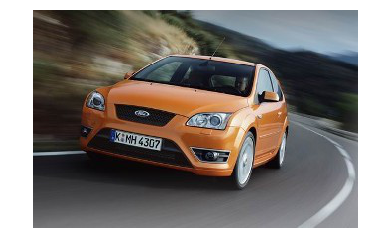

sports car, sport car (score = 0.66852)
convertible (score = 0.13973)
car wheel (score = 0.05962)
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (score = 0.02409)
minivan (score = 0.01137)

images/cat.jpg


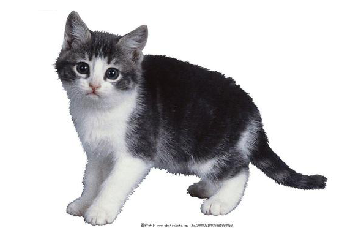

tabby, tabby cat (score = 0.71955)
Egyptian cat (score = 0.17138)
tiger cat (score = 0.03862)
Persian cat (score = 0.00451)
lynx, catamount (score = 0.00418)

images/chair.jpg


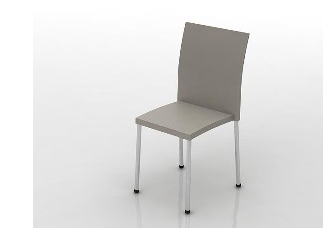

desk (score = 0.27513)
dining table, board (score = 0.15208)
studio couch, day bed (score = 0.07667)
wardrobe, closet, press (score = 0.03834)
pedestal, plinth, footstall (score = 0.01380)

images/cup.jpg


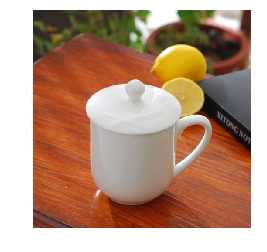

coffeepot (score = 0.37174)
cup (score = 0.15566)
coffee mug (score = 0.12894)
teapot (score = 0.05074)
eggnog (score = 0.02323)

images/dot.jpg


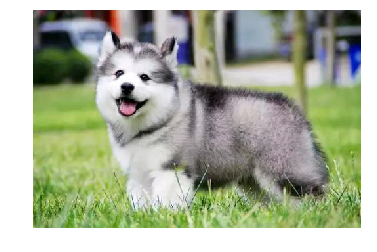

malamute, malemute, Alaskan malamute (score = 0.59332)
Eskimo dog, husky (score = 0.21528)
Siberian husky (score = 0.07246)
Norwegian elkhound, elkhound (score = 0.00384)
dogsled, dog sled, dog sleigh (score = 0.00208)

images/microphone.jpg


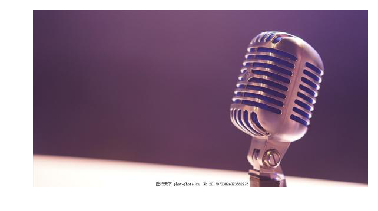

microphone, mike (score = 0.96884)
coil, spiral, volute, whorl, helix (score = 0.00258)
goblet (score = 0.00072)
torch (score = 0.00054)
spotlight, spot (score = 0.00050)



In [6]:
# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root, dirs, files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root, file), 'rb').read()
            preditions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})  # 图片格式是jpg格式
            preditions = np.squeeze(preditions)  # 把结果转为1维数据
            
            # 打印图片路径及名称
            image_path = os.path.join(root, file)
            print(image_path)
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # 排序
            top_k = preditions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = preditions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()
